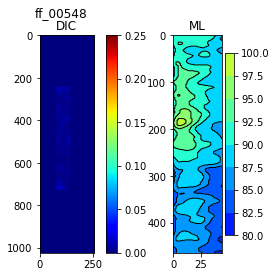

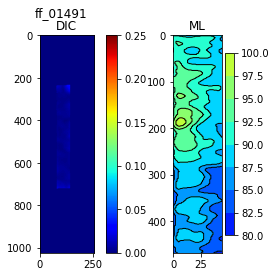

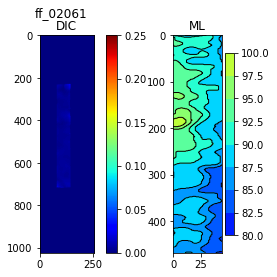

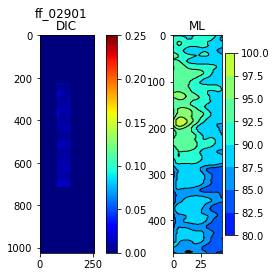

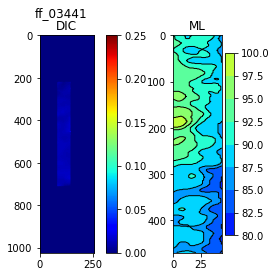

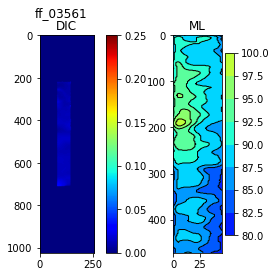

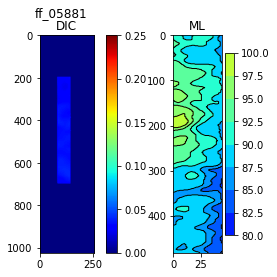

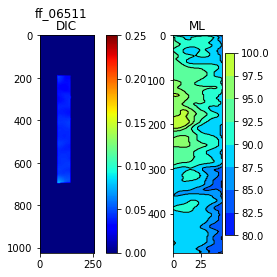

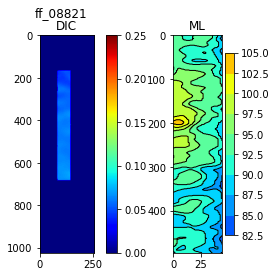

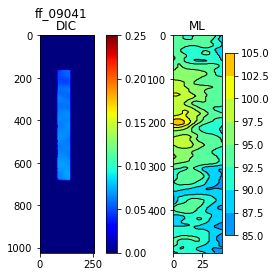

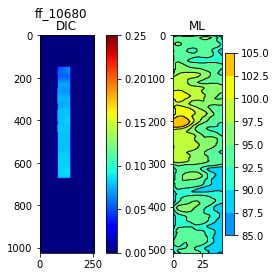

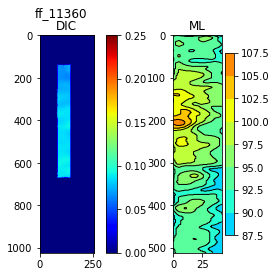

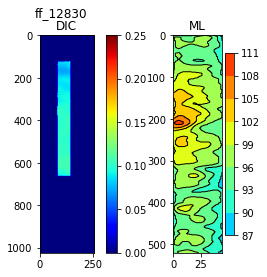

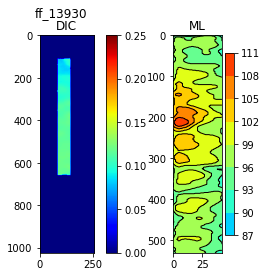

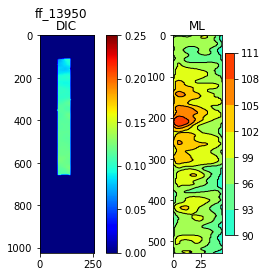

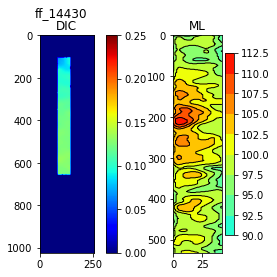

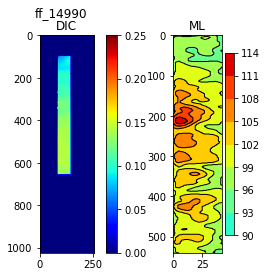

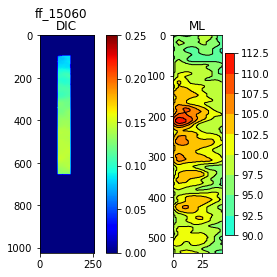

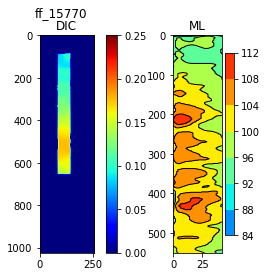

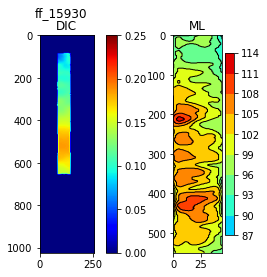

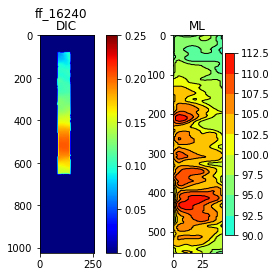

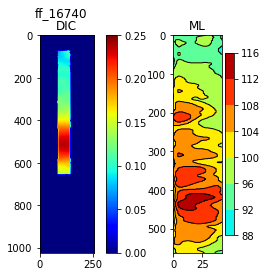

In [209]:
import os
import cv2
import sys
from scipy import io
import pandas as pd
from scipy.spatial import distance
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import fracture
import DIC as dic

"""
Matlab코드 여러 Dic데이터있는경우
path = 'D:/faruv_tension_2/slectpic/data'

for i=1:1:22
uu=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

path = r'D:\faruv_tension_2\slectpic'
save_path =r'D:\faruv_tension_2\slectpic/output'
image = dic.load_file(path)

ref = ml_image = image[list(image.keys())[0]]

for num in range(1,22+1):
    file_num = str(num)
    uu = io.loadmat(path+'/data/'+file_num+'_uu.mat')['uu']
    vv = io.loadmat(path+'/data/'+file_num+'_vv.mat')['vv']
    uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
    vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

    exx = io.loadmat(path+'/data/'+file_num+'_exx.mat')['exx']
    eyy = io.loadmat(path+'/data/'+file_num+'_eyy.mat')['eyy']
    exy = io.loadmat(path+'/data/'+file_num+'_exy.mat')['exy']
    ee = fracture.effective_strain(exx, eyy, exy)
    exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
    eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
    exy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
    ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

    ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')
    ml_image = image[list(image.keys())[num]]
    mask_ml = dic.find_zone(cv2.copyTo(ml_image, ee_mask))

    gas = cv2.GaussianBlur(mask_ml[:,:,1],(0,0),5)[10:-10,10:-10]
    # gas = cv2.GaussianBlur(ml_image[:,:,1][260:702,71:149],(0,0),5)
    # gas = mask_ml[:,:,1]

    fig, ax = plt.subplots(1, 2 , gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(list(image.keys())[num])
    ax1 = ax[0].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
    ax[0].set_title('DIC')


    ax2 = ax[1].contourf(gas,cmap='jet', vmin=75, vmax=116)
    ax3 = ax[1].contour(gas,colors='black',linewidths=1)
    ax[1].invert_yaxis()
    # plt.imshow(mask_ml)
    plt.colorbar(ax2, ax=ax[1])
    # ax[1].axis('off')
    ax[1].set_title('ML')

    plt.colorbar(ax1,ax=ax[0])

    plt.savefig(save_path+'/'+list(image.keys())[num]+'.png', dpi=300)
    plt.show()
    plt.close()
    # print(np.shape(gas))
